# Use-case: Recording of pyramidal neurons in weakly electric fish

-- Benda Lab, University of Tübingen, Germany --

**Context**
- Single cell recordings of pyramidal neurons with sharp electrodes
- Four simultaneously recorded signals digitized @100 kHz:
    1. Intracellular potentials.
    2. The fish's electric field.
    3. The transdermal potential (own field + stimulus).
    4. The stimulus.
- Event traces:
    1. Detected action potentials.
    2. Detected electric organ discharges.
    3. Beats in the electric field.
    4. Restart events of the DAQ board.
- Recording with the custom written *RELACS* software (www.relacs.net)

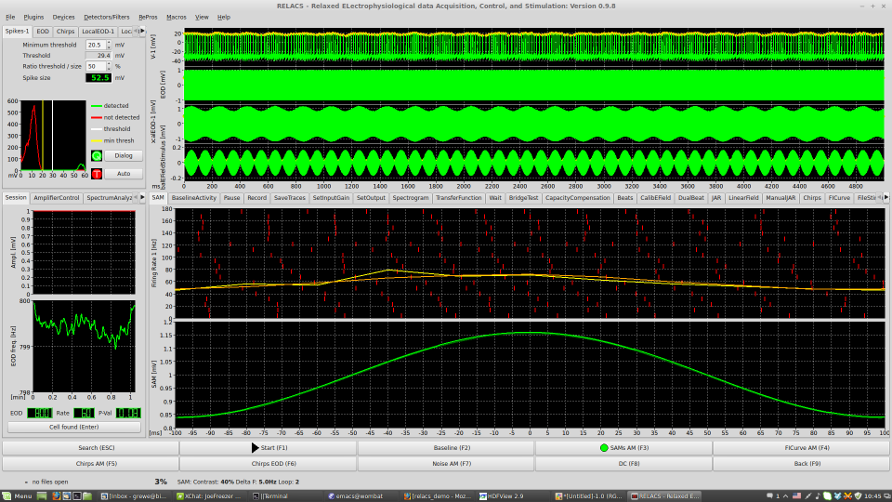

In [1]:
from IPython.core.display import Image 
Image(filename='relacs.png')

In [2]:
import nixio as nix
import numpy as np
import matplotlib.pylab as plt
from utils.notebook import print_stats
from utils.notebook import print_metadata_table
from utils.plotting import Plotter
%matplotlib inline

# File inventory:

In [2]:
# open file
nix_file = nix.File.open('data/relacs.h5')
# list the contents of the dataset
print_stats(nix_file.blocks)


Blocks                                             (01)
	type: nix.recording                        (01)


In [3]:
b = nix_file.blocks[0]
print_stats(b.data_arrays)
print_stats(b.multi_tags)


DataArrays                                         (09)
	type: nix.event.1D_extents                 (01)
	type: nix.event.1D_positions               (01)
	type: nix.1D-sampled.voltage_trace         (04)
	type: nix.event.positions                  (02)
	type: nix.feature.amplitudes               (01)

MultiTags                                          (03)
	type: nix.events.daq_restart               (01)
	type: nix.epoch.stimulus                   (01)
	type: nix.events.spike_times               (01)


## Metadata support:

We store a lot of metadata along with the data. In this example we show only those related with the recording session and some infromation about the recorded cell. 

RECORDING METADATA


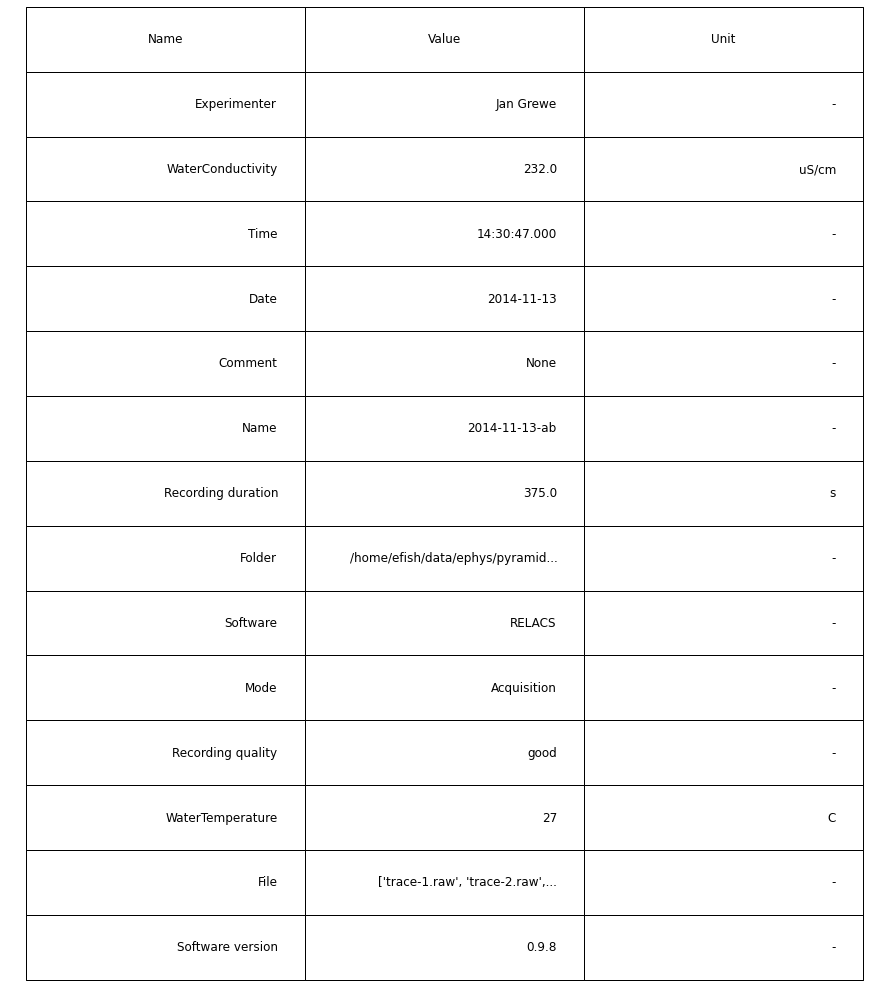

In [4]:
fig = print_metadata_table([s for s in b.metadata.sections if s.name == 'Recording'][0])
print('RECORDING METADATA')
plt.show()


CELL METADATA


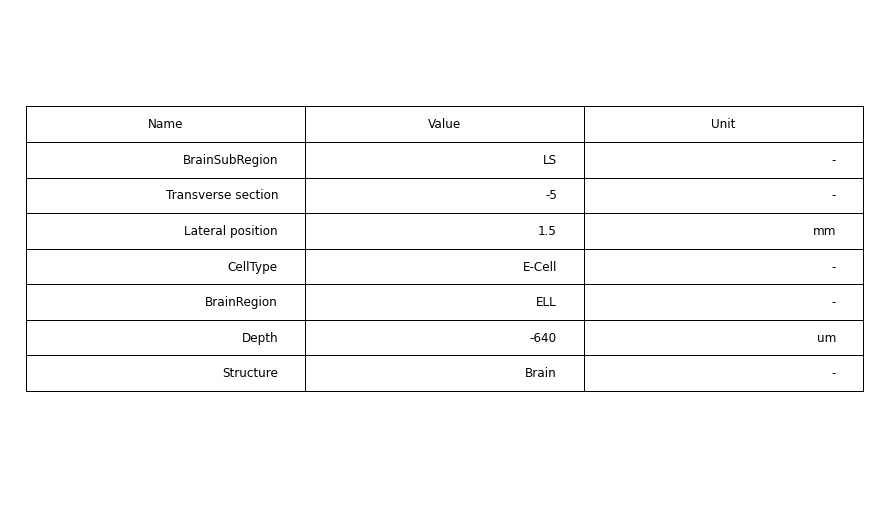

In [5]:
fig = print_metadata_table([s for s in b.metadata.sections if s.name == 'Cell'][0])
print('CELL METADATA')
plt.show()


## Plot data traces:

We record four raw traces which are stored in individual **DataArrays**. All have been sampled in regular intervals.

In [6]:
# get the data from nix file
voltage = [da for da in b.data_arrays if da.name == "V-1"][0]
eod = [da for da in b.data_arrays if da.name == "EOD"][0]
local_eod = [da for da in b.data_arrays if da.name == "LocalEOD-1"][0]
stim = [da for da in b.data_arrays if da.name == "GlobalEFie"][0]

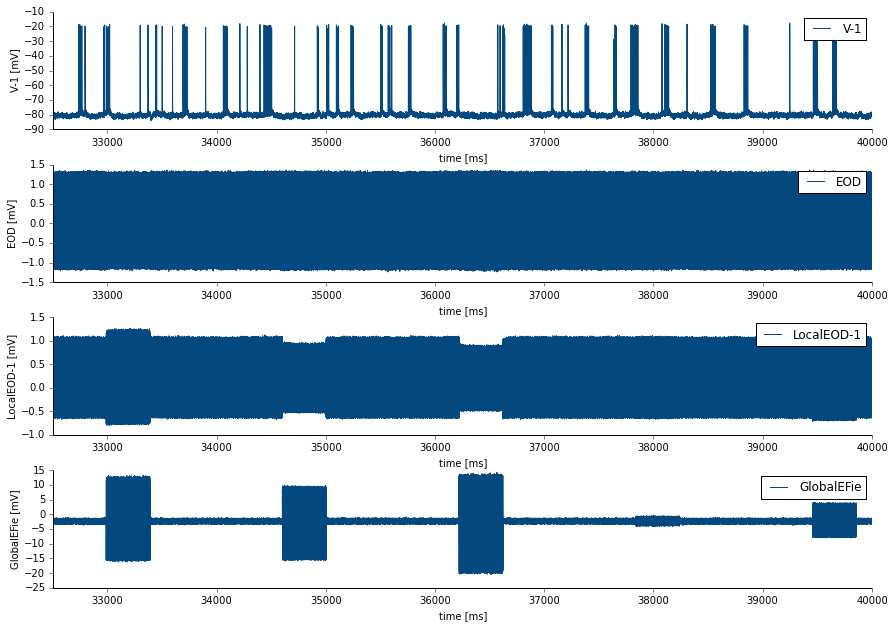

In [7]:
plotter = Plotter(width=1280, height=800,lines=4)
plotter.add(voltage, 0, xlim=[32500, 40000])
plotter.add(eod, 1, xlim=[32500, 40000])
plotter.add(local_eod, 2, xlim=[32500, 40000])
plotter.add(stim, 3, xlim=[32500, 40000])
plotter.plot()

## Plot spike time events

Different events are recorded. Most imporatantly we detect spikes online and store their times. For each spike we also record its amplitude (not shown in this example).

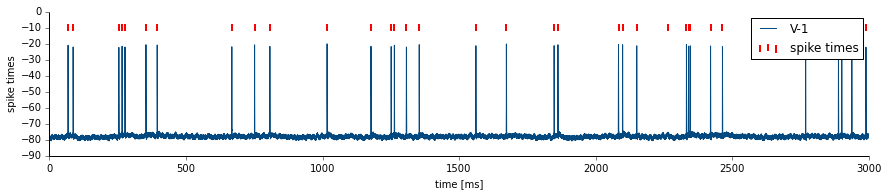

In [8]:
spike_times = [da for da in b.data_arrays if da.name == "spike times"][0]
plotter = Plotter(width=1280, height=200,lines=1)
plotter.add(voltage, 0, xlim=[0, 3000])
plotter.add(spike_times, xlim=[0, 3000], color="red")
plotter.plot()

## Stimulus epochs

During certain epochs of the recording, a stimulus is presented. In this case, signals of different amplitudes to estimate the **F**ring rate vs. **I**ntensity-curve of that neuron.

Stimulus times are defined by their respective start times and extents.

In [9]:
# get onset and duration of stimulus epochs
stim_times = [da for da in b.data_arrays if da.name == "FICurve start positions"][0]
stim_extents = [da for da in b.data_arrays if da.name == "FICurve extents"][0]

# create a time axis and cut out an iteresting section of the data
sampling_interval = voltage.dimensions[0].sampling_interval
time_axis = np.arange(len(voltage))*sampling_interval
min_time, max_time = 32.5, 35.
stim_positions = stim_times[:][(stim_times[:] > min_time) & (stim_times[:] < max_time)]*1000
stim_extents = stim_extents[:][(stim_times[:] > min_time) & (stim_times[:] < max_time)]*1000


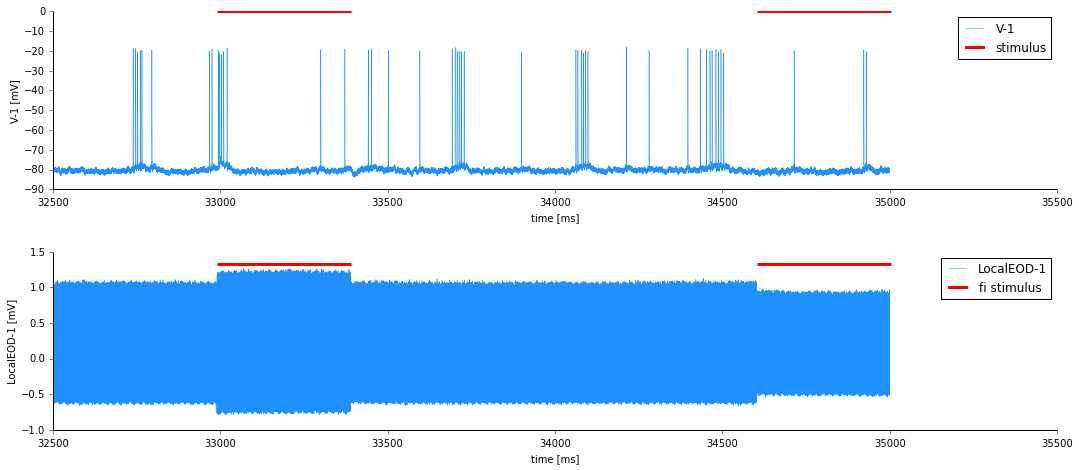

In [10]:
# plot data, mark stimulus sections with red lines
fig = plt.figure(facecolor='white', figsize=(18.,7.5))
    
ax = fig.add_subplot(211)
ax.tick_params(direction='out')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.plot(time_axis[(min_time*100000):(max_time*100000)], voltage[:][(min_time*100000):(max_time*100000)], lw=0.5,
        color='dodgerblue', label=voltage.name)
ax.hlines(np.zeros_like(stim_positions), stim_positions, stim_positions+stim_extents, color='red', 
          lw=3., label='stimulus')
ax.set_xlabel(voltage.dimensions[0].label + ' [' + voltage.dimensions[0].unit + ']')
ax.set_ylabel(voltage.label + ' [' + voltage.unit + ']')
ax.legend()

ax = fig.add_subplot(212)
ax.tick_params(direction='out')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.plot(time_axis[min_time*100000:max_time*100000], local_eod[:][min_time*100000:max_time*100000], lw=0.5,
        color='dodgerblue', label=local_eod.name, zorder=0)
ax.hlines(np.ones_like(stim_positions)*np.max(local_eod), stim_positions, stim_positions+stim_extents, color='red',
          lw=3., label='fi stimulus',zorder=1)
ax.set_xlabel(local_eod.dimensions[0].label + ' [' + local_eod.dimensions[0].unit + ']')
ax.set_ylabel(local_eod.label + ' [' + local_eod.unit + ']')
fig.subplots_adjust(hspace=0.35, wspace=0.15)
ax.legend()
plt.show()


In [11]:
 nix_file.close()